In [2]:
import pandas as pd
import os
import pandas as pd
import spacy
from multiprocessing import Pool, cpu_count
from string import punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

#from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc



In [3]:
pwd = os.getcwd()
df = pd.read_csv(pwd + "/data/reviews_amazon.csv")
df.head()

,Unnamed: 0,date,reviewNo,employeeType,position,summary,pro,con,advice,overallStar,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,reviewLink
0,1,"Feb 7, 2017",empReview_13664891,Current Employee - Software Development Engineer,I have been working at Amazon (More than a year),Kinda crappy,* Pay is good* Non idiotic approach to enginee...,* The company activly encourages everyone to t...,"I'm used to work being something like ""Hello _...",3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...
1,2,"Mar 1, 2017",empReview_13996510,Former Employee - Anonymous Employee,I worked at Amazon part-time,Fulfillment,"Great coworkers, always moving, and easy work .",Can be held over for up to 2 additional hours.,Stop employees from hiding in the restroom .,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...
2,3,"Mar 1, 2017",empReview_13997995,Current Employee - Anonymous Employee,None,Good company if you do your job,Decent pay for a job that isn't too hard.,If you don't like long days with little notice...,Management should be a little more compassiona...,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...
3,4,"Mar 15, 2017",empReview_14192639,Current Employee - Anonymous Employee,I have been working at Amazon full-time,Fulfillment associate,If you're late you can use your personal time ...,It breaks and lunch should be longer because o...,mayfair and just with the employees and follow...,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...
4,5,"Mar 15, 2017",empReview_14199877,Former Employee - Anonymous Employee,I worked at Amazon full-time,Fulfillment Associate,"Easy job, but not much else",Hours are pretty damn brutal,None,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...


# To Do:
For Pros and Cons of the reviews, process the data for NLP analysis by 
- removing Stop Words 
- Stemming/Lemmatizing
- Analyzing the corpus using TF-IDF to find top words in each category
- Use word cloud to look at most common topics
- Sentiment analysis on the reviews
- Can sentiments be correlated to rating? How would you weight Pros & Cons to arrive at Review Rating??
- Can we build a model to predict rating from reviews??
- Does the review depend on type of job?
- How is the rating trend over time?

In [4]:
df.rename(columns={"Unnamed: 0":'reviewNum'}, inplace=True)
df.columns

Index(['reviewNum', 'date', 'reviewNo', 'employeeType', 'position', 'summary',
       'pro', 'con', 'advice', 'overallStar', 'workLifeStar', 'cultureStar',
       'careerOppStar', 'comBenefitsStar', 'srManagementStar', 'reviewLink'],
      dtype='object')

In [5]:
# clean_text
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
STOPLIST = set(["n't", "'s", "'m", "ca", "'", "'re", "i've", 'poor', '-',
                'worst', 'place', 'make', 'thing', 'hour', 'low', 'high', 'bos',
                'good', 'great', 'awesome', 'excellent', 'job', 'best', 'lot',
                'wonderful', 'awful', 'work', 'amazing', 'suck', 'nice',
                'really', 'free', 'like', 'love', 'bad', 'terrible', 'care',
                'horrible', 'company', 'employee', 'staff', 'time', 'day',
                'week', 'month', 'year', 'need', 'better', 'just', 'decent', 'I', 'me', 'my', 'My', 'PRON'] +
               list(ENGLISH_STOP_WORDS))

In [6]:
KEEP_POS = {'ADJ', 'ADP', 'ADV', 'NOUN', 'VERB'}
nlp = spacy.load('en')


In [7]:
def multi_scrub_text(reviews):
    '''
    Function to lemmatize text - utilizes multiprocessing for parallelization
    INPUT:
        reviews: array-like, pandas DataFrame column containing review texts
    OUTPUT:
        lemmatized: pandas DataFrame column with cleaned texts
    '''
    lemmatized = []
    cpus = cpu_count() - 1
    pool = Pool(processes=cpus)
    lemmatized = pool.map(lemmatize_text, reviews)
    pool.close()
    pool.join()
    return lemmatized


def lemmatize_text(text, stop_words=STOPLIST, keep_pos=KEEP_POS):
    '''
    Function to lemmatize a single document of the corpus
    INPUT:
        text: string, text of review
        stop_words: words to remove from text, default STOPLIST defined above
        keep_pos: parts of speech to keep in text, default KEEP_POS def above
    OUTPUT:
        lemmatized text
    '''
    x = nlp(text)
    words = [tok.lemma_.strip(punctuation) for tok in x if (
        tok.pos_ in keep_pos) and (tok.lemma_.strip(punctuation) not in STOPLIST)]
    words.extend(['boss' for tok in x if tok.lemma_ == 'bos'])
    return ' '.join(words)

In [8]:
pros_df = pd.DataFrame()
cons_df = pd.DataFrame()
#print(lemmatize_text(df['pro'].astype(str)))
#print(multi_scrub_text(df['pro']))
pros_df['lemmatized_text'] = multi_scrub_text(df['pro'])

cons_df['lemmatized_text'] = multi_scrub_text(df['con'])

In [9]:
df['lem_pro'] = multi_scrub_text(df['pro'])
df['lem_con'] = multi_scrub_text(df['con'])

In [10]:
df.head()

,reviewNum,date,reviewNo,employeeType,position,summary,pro,con,advice,overallStar,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,reviewLink,lem_pro,lem_con
0,1,"Feb 7, 2017",empReview_13664891,Current Employee - Software Development Engineer,I have been working at Amazon (More than a year),Kinda crappy,* Pay is good* Non idiotic approach to enginee...,* The company activly encourages everyone to t...,"I'm used to work being something like ""Hello _...",3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,pay non idiotic approach engineering learn eng...,activly encourage treat inhuman tool crappy le...
1,2,"Mar 1, 2017",empReview_13996510,Former Employee - Anonymous Employee,I worked at Amazon part-time,Fulfillment,"Great coworkers, always moving, and easy work .",Can be held over for up to 2 additional hours.,Stop employees from hiding in the restroom .,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,coworker easy,hold additional
2,3,"Mar 1, 2017",empReview_13997995,Current Employee - Anonymous Employee,None,Good company if you do your job,Decent pay for a job that isn't too hard.,If you don't like long days with little notice...,Management should be a little more compassiona...,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,pay hard,long little notice schedule change bother
3,4,"Mar 15, 2017",empReview_14192639,Current Employee - Anonymous Employee,I have been working at Amazon full-time,Fulfillment associate,If you're late you can use your personal time ...,It breaks and lunch should be longer because o...,mayfair and just with the employees and follow...,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,late use personal clock half unpaid lunch minu...,break lunch long pressure rate meet processing...
4,5,"Mar 15, 2017",empReview_14199877,Former Employee - Anonymous Employee,I worked at Amazon full-time,Fulfillment Associate,"Easy job, but not much else",Hours are pretty damn brutal,None,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,easy,pretty damn brutal


# Lets find out what employees find most positive and most negative about the company
- Lets plot word frequency graph 
- Lets plot wordcloud

In [11]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [12]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
#from stop_words import get_stop_words
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

top_N = 100
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

a = df['lem_pro'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
#stop_words = list(get_stop_words('en'))         
#nltk_words = list(stopwords.words('english'))   
#stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in STOPLIST]
filtered_sentence = []
for w in word_tokens:
    if w not in STOPLIST:
        filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])


# Word Frequency count on positive reviews

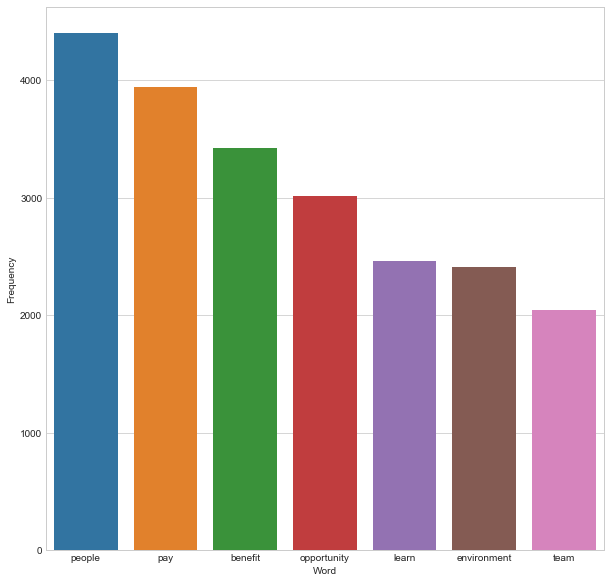

In [13]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

# Word Cloud on Pros

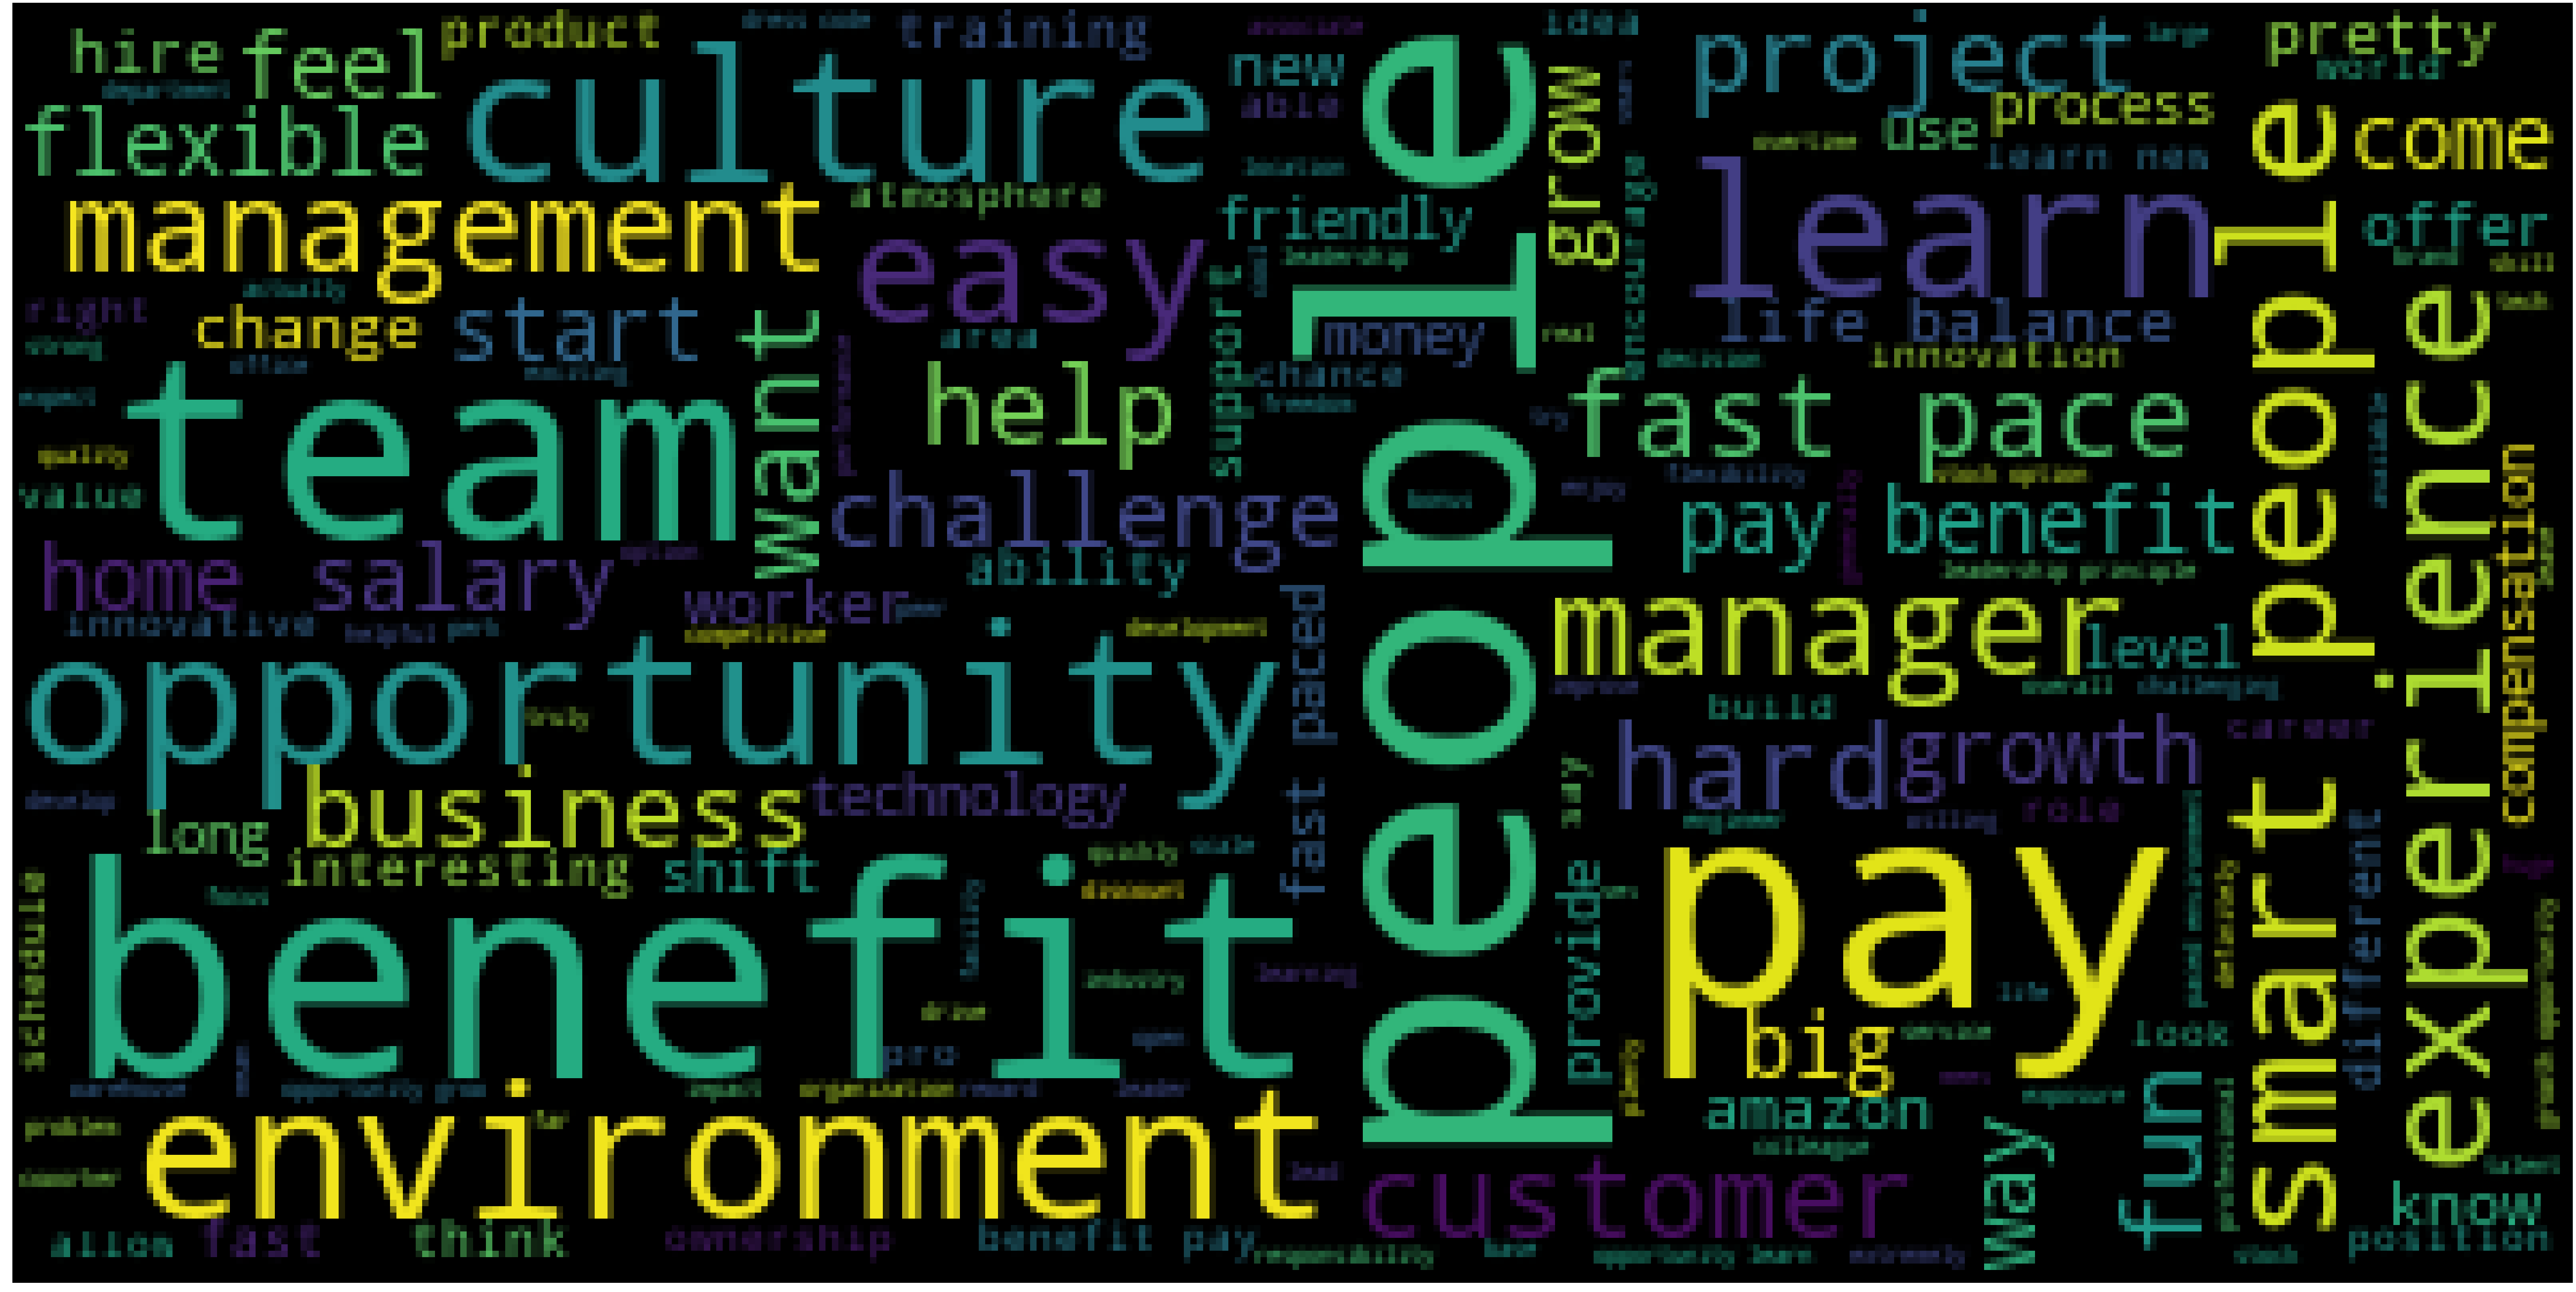

In [14]:
wc(cleaned_data_title,'black','Common Words' )

In [15]:
top_N = 100
#convert list of list into text

a = df['lem_con'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
#stop_words = list(get_stop_words('en'))         
#nltk_words = list(stopwords.words('english'))   
#stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in STOPLIST]
filtered_sentence = []
for w in word_tokens:
    if w not in STOPLIST:
        filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

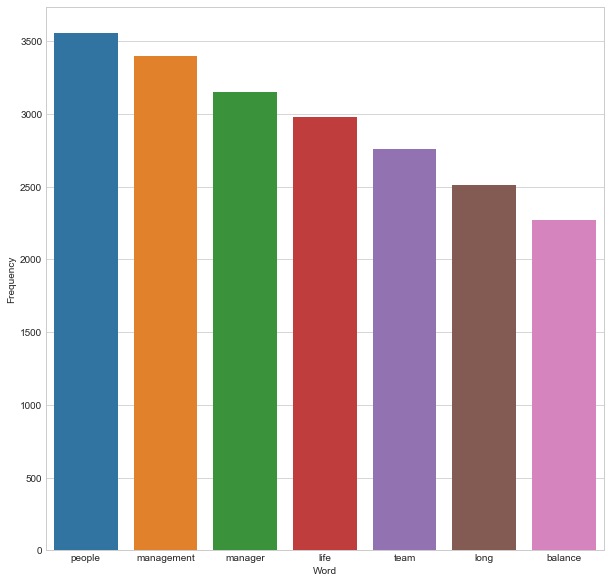

In [16]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

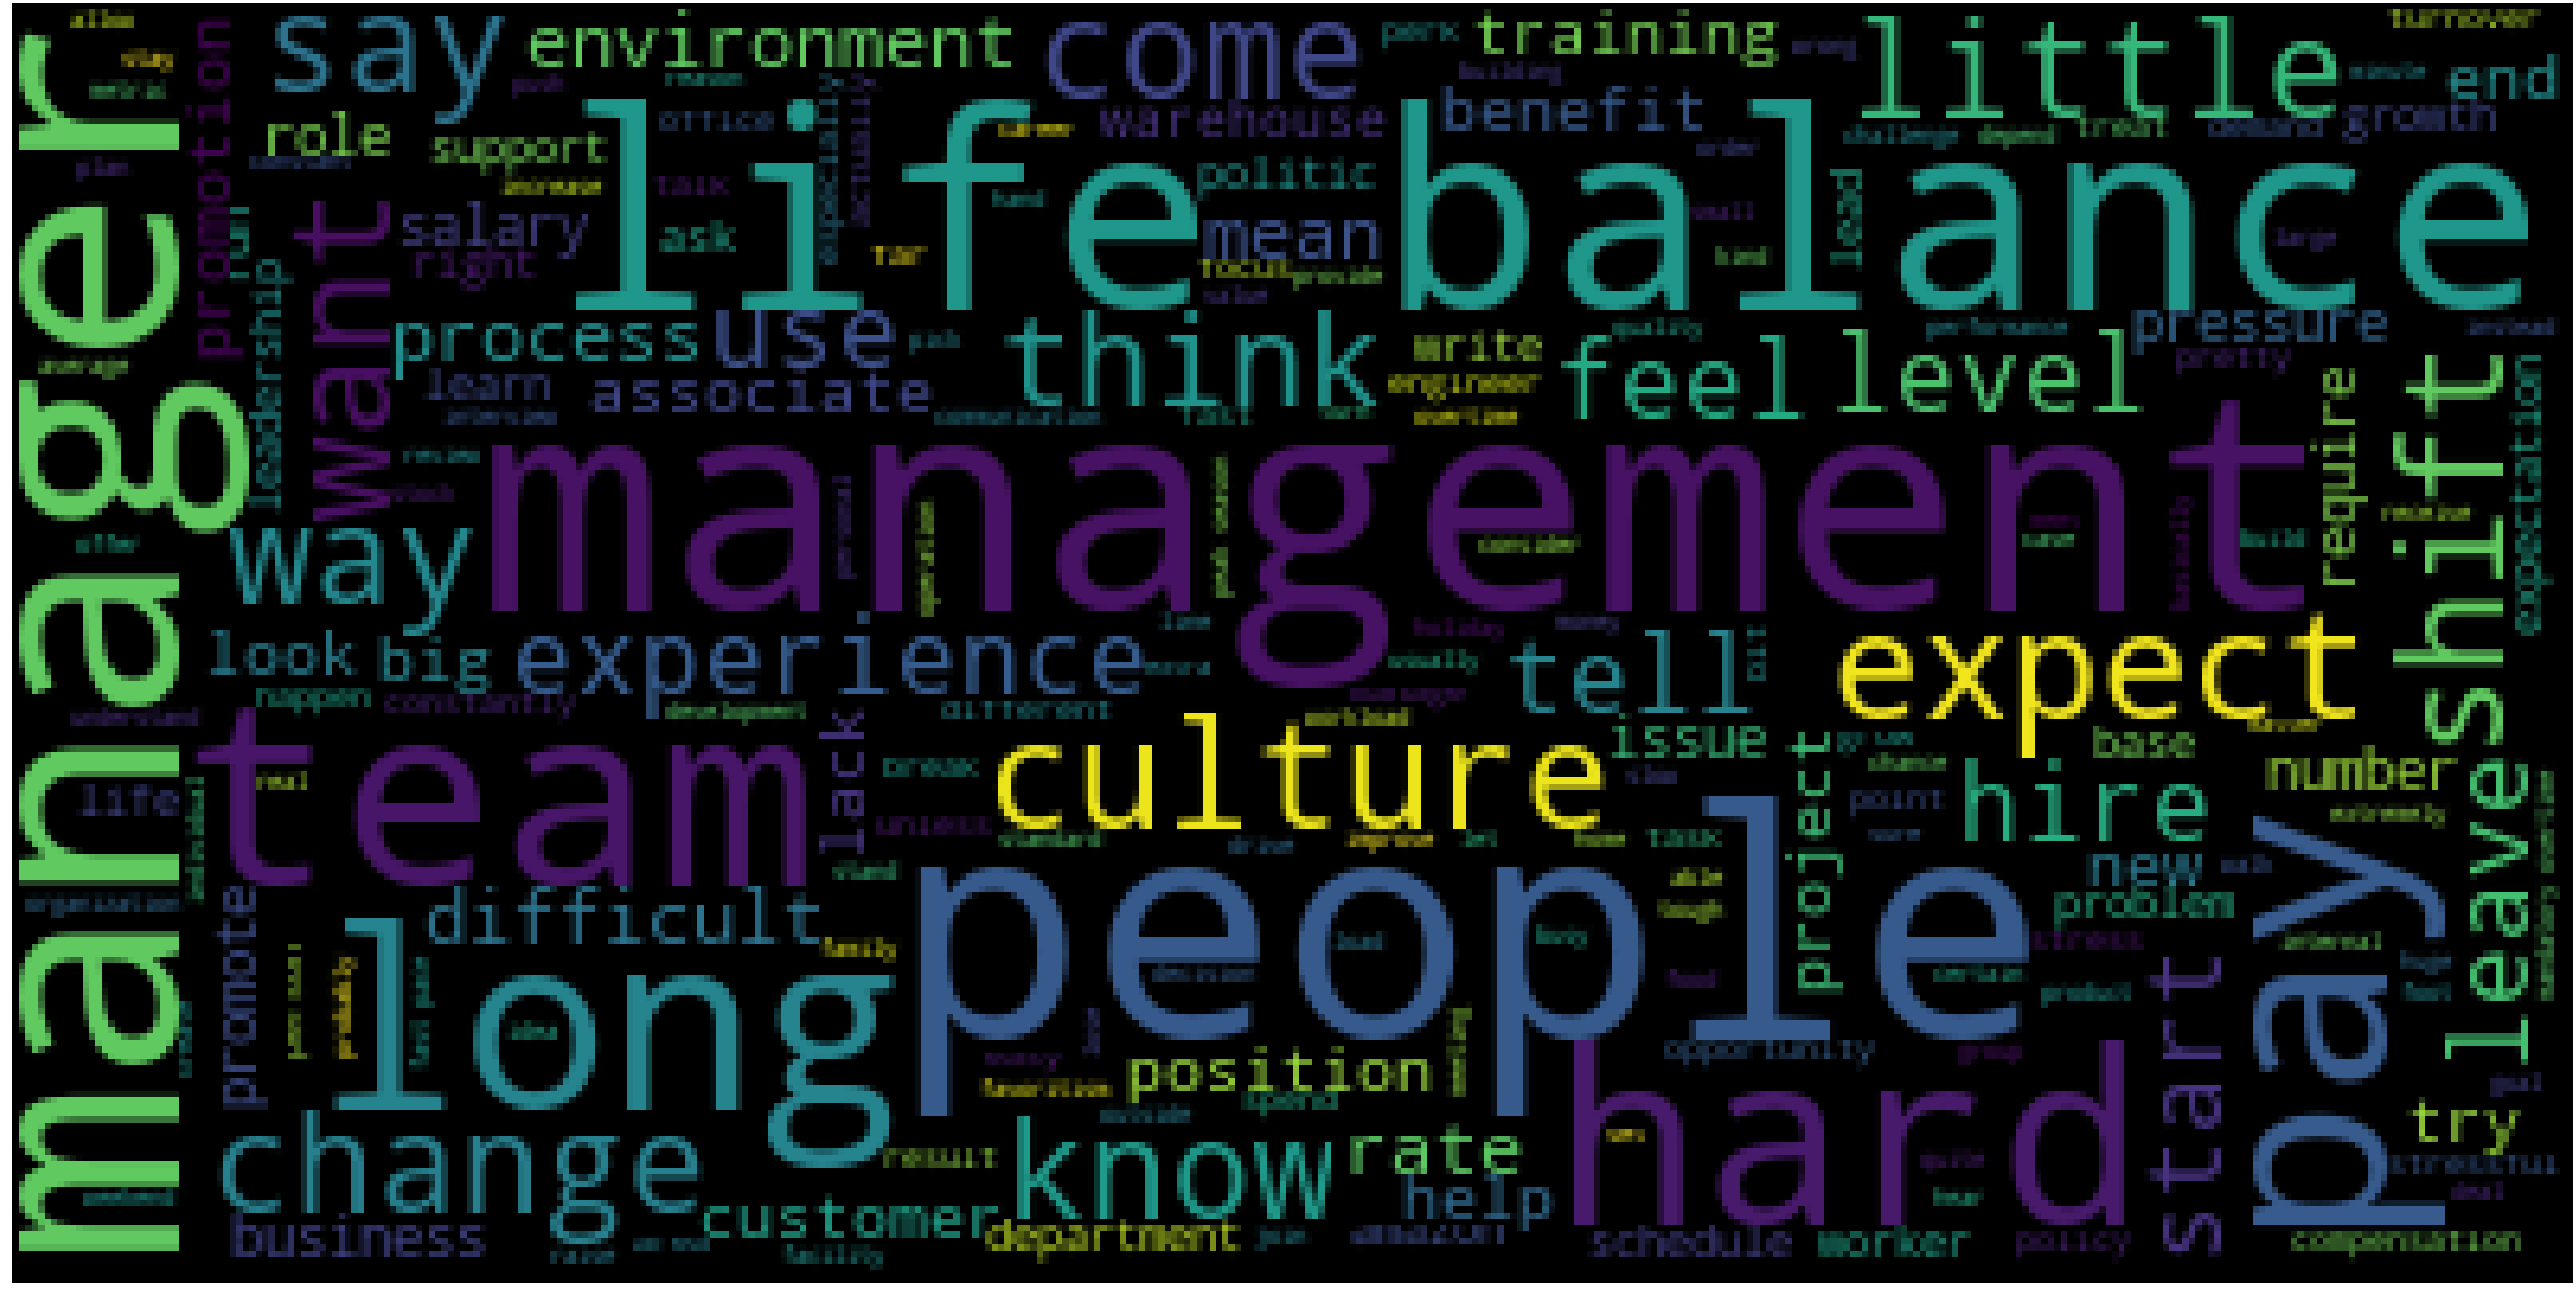

In [17]:
wc(cleaned_data_title,'black','Common Words' )

# Analyze sentiment of positive reviews

In [18]:
from textblob import TextBlob

In [19]:
txt_pro = df['pro'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_pro)
print (blob)

* pay is good* non idiotic approach to engineering* i learned a lot about engineering in my year here* pay is pretty good* seattle is a nice place to live i think* teaches you that theres more to life than work by virtue of shoving in your face how distasteful workaholics are great coworkers, always moving, and easy work . decent pay for a job that isn't too hard. if you're late you can use your personal time to clock in. do you work for 10 hour days and get a half hour unpaid lunch 210 minute breaks easy job, but not much else your fellow associates are the only reason to work here, they are good people. very customer focused and ambitious great experience about the environment there you could work four 10-hour days at $13.00 or three 12-hour shifts for $16.00. interesting work, challenging, tangible accomplishments, growth opportunities.good location in slu.ability to try completely different/new things, i.e. move from retail to aws, kindle, video, publishing, imdb, zappos, etc. the 

In [20]:
blob.sentiment

Sentiment(polarity=0.34197689340867093, subjectivity=0.5739943073369556)

In [21]:
txt_con = df['con'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_con)
print (blob)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
blob.sentiment

Sentiment(polarity=0.033926443265957604, subjectivity=0.49576194084868047)

# Does lematized review improve the sentiment polarity?

In [23]:
txt_pro = df['lem_pro'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_pro)
blob.sentiment

Sentiment(polarity=0.16945874949009246, subjectivity=0.5453465064593608)

In [24]:
txt_pro = df['lem_con'].str.lower().str.cat(sep=' ')
blob = TextBlob(txt_pro)
blob.sentiment

Sentiment(polarity=-0.023151551916701745, subjectivity=0.5118929678973424)

In [25]:
# Well, apparently, lematization does not help with sentiment function

In [26]:
df.overallStar.value_counts()

4.0    7020
5.0    6237
3.0    4847
2.0    2430
1.0    2112
Name: overallStar, dtype: int64

In [27]:
df['review'] = df['pro']  + df['con']
df['length'] = df['review'].apply(len)
df.head()

,reviewNum,date,reviewNo,employeeType,position,summary,pro,con,advice,overallStar,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,reviewLink,lem_pro,lem_con,review,length
0,1,"Feb 7, 2017",empReview_13664891,Current Employee - Software Development Engineer,I have been working at Amazon (More than a year),Kinda crappy,* Pay is good* Non idiotic approach to enginee...,* The company activly encourages everyone to t...,"I'm used to work being something like ""Hello _...",3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,pay non idiotic approach engineering learn eng...,activly encourage treat inhuman tool crappy le...,* Pay is good* Non idiotic approach to enginee...,1591
1,2,"Mar 1, 2017",empReview_13996510,Former Employee - Anonymous Employee,I worked at Amazon part-time,Fulfillment,"Great coworkers, always moving, and easy work .",Can be held over for up to 2 additional hours.,Stop employees from hiding in the restroom .,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,coworker easy,hold additional,"Great coworkers, always moving, and easy work ...",93
2,3,"Mar 1, 2017",empReview_13997995,Current Employee - Anonymous Employee,None,Good company if you do your job,Decent pay for a job that isn't too hard.,If you don't like long days with little notice...,Management should be a little more compassiona...,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,pay hard,long little notice schedule change bother,Decent pay for a job that isn't too hard.If yo...,122
3,4,"Mar 15, 2017",empReview_14192639,Current Employee - Anonymous Employee,I have been working at Amazon full-time,Fulfillment associate,If you're late you can use your personal time ...,It breaks and lunch should be longer because o...,mayfair and just with the employees and follow...,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,late use personal clock half unpaid lunch minu...,break lunch long pressure rate meet processing...,If you're late you can use your personal time ...,263
4,5,"Mar 15, 2017",empReview_14199877,Former Employee - Anonymous Employee,I worked at Amazon full-time,Fulfillment Associate,"Easy job, but not much else",Hours are pretty damn brutal,None,3.0,3.0,3.0,3.0,3.0,3.0,https://www.glassdoor.com/Reviews/Amazon-Revie...,easy,pretty damn brutal,"Easy job, but not much elseHours are pretty da...",55


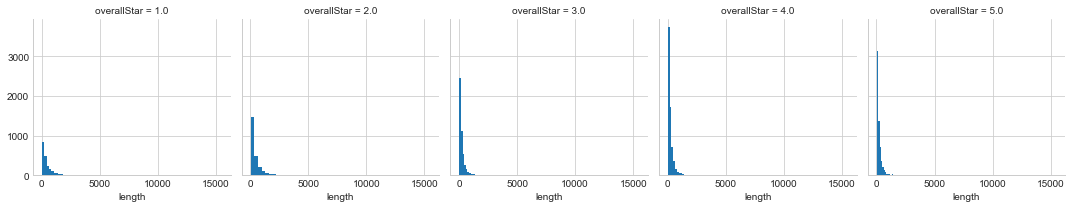

In [28]:
# Is there a correlation between review length & rating?
import seaborn as sns
g = sns.FacetGrid(data=df, col='overallStar')
g.map(plt.hist, 'length', bins=50)
# It does appear that people with higher rating write longer reviews and data is skewed towards positive reviews

In [29]:
# visualizing correlations in dataframe
stars = df.groupby('overallStar').mean()
stars.corr()

,reviewNum,workLifeStar,cultureStar,careerOppStar,comBenefitsStar,srManagementStar,length
reviewNum,1.000000,0.098762,0.098762,0.098762,0.098762,0.098762,-0.307880
workLifeStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
cultureStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
careerOppStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
comBenefitsStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
srManagementStar,0.098762,1.000000,1.000000,1.000000,1.000000,1.000000,-0.929224
length,-0.307880,-0.929224,-0.929224,-0.929224,-0.929224,-0.929224,1.000000


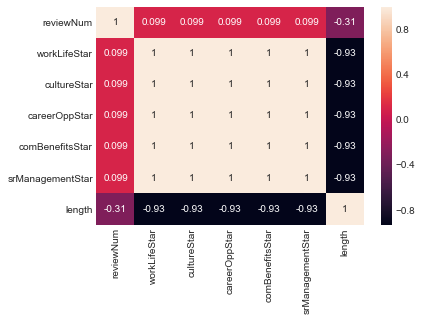

In [30]:
sns.heatmap(data=stars.corr(), annot=True)
# not useful at all

# Predictions
- Goal is to predict rating or classify review as positive or negative

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
df.shape

(22646, 21)

In [37]:
# lets create X & Y for our classification task
X = df['review']
y = df['overallStar']

# 1. Baseline Model
Assign average rating as the predicted rating.

In [38]:

df['predicted_rating'] = round(sum(df.overallStar)/len(df.index))

print ("Baseline Rating:", round(sum(df.overallStar)/len(df.index)))

Baseline Rating: 4


In [39]:
t = df[['overallStar', 'predicted_rating']]

In [40]:
print(confusion_matrix(t.overallStar, t.predicted_rating))
print('\n')
print(classification_report(t.overallStar, t.predicted_rating))

[[   0    0    0 2112    0]
 [   0    0    0 2430    0]
 [   0    0    0 4847    0]
 [   0    0    0 7020    0]
 [   0    0    0 6237    0]]


             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      2112
        2.0       0.00      0.00      0.00      2430
        3.0       0.00      0.00      0.00      4847
        4.0       0.31      1.00      0.47      7020
        5.0       0.00      0.00      0.00      6237

avg / total       0.10      0.31      0.15     22646



/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
# We need to create a feature vector out of review text using bag of words and vectorization so that we can classify
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [42]:
 # Use CountVectorizer to convert the text collection into a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
bow_t = CountVectorizer(analyzer=text_process).fit(X)
len(bow_t.vocabulary_)

62562

In [43]:
review_25 = X[24]
review_25

'Good place to work, a lot to learn.There is no cons for now.'

In [44]:
bow_25 = bow_t.transform([review_25])
print(bow_25)

  (0, 4909)	1
  (0, 19738)	1
  (0, 36072)	1
  (0, 37181)	1
  (0, 45194)	1
  (0, 60732)	1


In [45]:
print(bow_t.get_feature_names()[1865])
print(bow_t.get_feature_names()[2782])

ArbeitsumfeldSehr
Canadian


In [46]:
X = bow_t.transform(X)

In [47]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (22646, 62562)
Amount of Non-Zero occurrences:  611682
Density: 0.04317412790205483


In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [49]:
# Multinomial Naive Bayes is a specialised version of Naive Bayes designed more for text documents.
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [50]:
# Testing and evaluating our model
preds = nb.predict(X_test)
# let’s evaluate our predictions against the actual ratings using confusion_matrix and classification_report 
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 258   54  164  166   37]
 [ 117   36  205  329   65]
 [  59   34  332  797  190]
 [  36   19  232 1325  469]
 [  23    8  132  866  841]]


             precision    recall  f1-score   support

        1.0       0.52      0.38      0.44       679
        2.0       0.24      0.05      0.08       752
        3.0       0.31      0.24      0.27      1412
        4.0       0.38      0.64      0.48      2081
        5.0       0.52      0.45      0.48      1870

avg / total       0.40      0.41      0.39      6794



In [51]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
    
#print(clf_)
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 56  20 140 263 200]
 [ 38  17 158 332 207]
 [ 40  16 322 653 381]
 [ 51  27 403 945 655]
 [ 32  25 306 747 760]]


             precision    recall  f1-score   support

        1.0       0.26      0.08      0.12       679
        2.0       0.16      0.02      0.04       752
        3.0       0.24      0.23      0.23      1412
        4.0       0.32      0.45      0.38      2081
        5.0       0.34      0.41      0.37      1870

avg / total       0.29      0.31      0.28      6794



In [60]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Random Forest', 'Logistic Regression', 'AdaBoost']
#  LDA(),  QDA(),
#  'LDA', 'QDA'
LDAResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(clf_)
    print(confusion_matrix(y_test, preds))
    print('\n')
    print(classification_report(y_test, preds))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
[[ 56  20 140 263 200]
 [ 38  17 158 332 207]
 [ 40  16 322 653 381]
 [ 51  27 403 945 655]
 [ 32  25 306 747 760]]


             precision    recall  f1-score   support

        1.0       0.26      0.08      0.12       679
        2.0       0.16      0.02      0.04       752
        3.0       0.24      0.23      0.23      1412
        4.0       0.32      0.45      0.38      2081
        5.0       0.34      0.41      0.37      1870

avg / total       0.29      0.31      0.28      6794

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
[[ 258   54  164  166   37]
 [ 117   36  205  329   65]
 [  59   34  332  797  190]
 [  36   19  232 1325  469]
 [  23    8  132  866  841]]


             precision    recall  f1-score   support

        1.0       0.52      0.38      0.44       679
        2.0       0.24      0.05   

# LIME
Local Interpretable Model-Agnostic Explanations (LIME)
LIME aims to explain a single prediction from any machine learning model 
by creating a approximation of the model locally near the data point using 
a simple model such as linear regression (the full details can be found in the paper )
Here we will use LIME to examine a prediction the model gets completely wrong to see what it might tell us about why the model makes mistakes.
First we need to find the observation our model gets most wrong. We do this by training and predicting with the model and extracting the example on which the model has the greatest error:

In [61]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the model with the best hyperparamters
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=100, random_state=42)

# Fit and test on the features
model.fit(X, y)
model_pred = model.predict(X_test)

# Find the residuals
residuals = abs(model_pred - y_test)
    
# Extract the most wrong prediction
wrong = X_test[np.argmax(residuals), :]

print('Prediction: %0.4f' % np.argmax(residuals))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


IndexError: index (17107) out of range

Next, we create the LIME explainer object passing it our training data, the mode, the training labels, and the names of the features in our data. Finally, we ask the explainer object to explain the wrong prediction, passing it the observation and the prediction function.

In [62]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [63]:
import lime 
import lime.lime_tabular

#feature_list = list(X_train.columns)

# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(X_train.dtype.names))


# Explanation for wrong prediction
exp = explainer.explain_instance(data_row = wrong, 
                                 predict_fn = model.predict)

# Plot the prediction explaination
exp.as_pyplot_figure();

TypeError: 'NoneType' object is not iterable

In [64]:
# Looks like the model is able to predict rating of 1 with 71% accuracy and 5 with 61% but fails on others
# Remembers that there is bias in data towards 5 stars or 1 stars so that is reflected in quality of predictions as well
# Stars #of reviews in the dataset
# 5.0    51
# 1.0    26
# 4.0    20
# 2.0    17
# 3.0     9

# How can we make the model better? Instead of just words, 
# should we build sentiment as part of featureset? Will that improve model??

In [65]:
# Add sentiment label which will be used to train sentiment classifier
def getSentiment(x):
    if x < 3.5:
        return 0
    else:
        return 1
# 1 is positive and 0 is not positive or negative

In [66]:
df['Sentiment'] = df['overallStar'].map(getSentiment)
# lets create X & Y for our classification task
X = df['review']
y = df['Sentiment']
bow_t = CountVectorizer(analyzer=text_process).fit(X)
X = bow_t.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
nb = MultinomialNB()
nb.fit(X_train, y_train)
# Testing and evaluating our model
preds = nb.predict(X_test)
# let’s evaluate our predictions against the actual ratings using confusion_matrix and classification_report 
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
# Predicting whether review is positive or negative is definitely more accurate than actual rating 1-5

[[1679 1164]
 [ 701 3250]]


             precision    recall  f1-score   support

          0       0.71      0.59      0.64      2843
          1       0.74      0.82      0.78      3951

avg / total       0.72      0.73      0.72      6794



In [67]:
# Now lets look at adding sentiment as one of the features to the model
#df['Sentiment'] = df['overallStar'].map(getSentiment)
# lets create X & Y for our classification task
X = df[['review','Sentiment']]
print(X.shape)
print(y.shape)
y = df['overallStar']
bow_t = CountVectorizer(analyzer=text_process).fit(X)
print(bow_t)
X = bow_t.transform(X)
print(type(X))
print(X.shape)
#X.append(df['Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print(X.shape)
print(y.shape)


(22646, 2)
(22646,)
CountVectorizer(analyzer=<function text_process at 0x1a3c616268>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)
<class 'scipy.sparse.csr.csr_matrix'>
(2, 2)


ValueError: Found input variables with inconsistent numbers of samples: [2, 22646]

In [68]:
y = df['overallStar']

bow_t = CountVectorizer(analyzer=text_process).fit(X)
X = bow_t.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
nb = MultinomialNB()
nb.fit(X_train, y_train)
# Testing and evaluating our model
preds = nb.predict(X_test)
# let’s evaluate our predictions against the actual ratings using confusion_matrix and classification_report 
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
# Predicting whether review is positive or negative is definitely more accurate than actual rating 1-5

TypeError: 'in <string>' requires string as left operand, not csr_matrix

# Next Steps
- Bag of words
- Vectorize
- Use train test split to get training set & test set
- Use Multinomial Naive Bayes model and fit it to training set
- Test and evaluate model
- Evaluate our predictions against the actual ratings
- Data Bias
- Revew the results against Logistic Classifier model

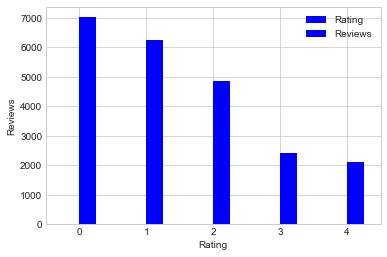

In [69]:
dfs = pd.DataFrame(df.overallStar.value_counts().reset_index())
#dfs
#dfs.columns
dfs.columns = ['Rating', 'Reviews']
dfs.apply(pd.to_numeric)
dfs.info

dfs.plot(kind='bar', color='blue')
plt.xlabel('Rating')
plt.ylabel('Reviews')
plt.xticks(rotation=0)
plt.show()

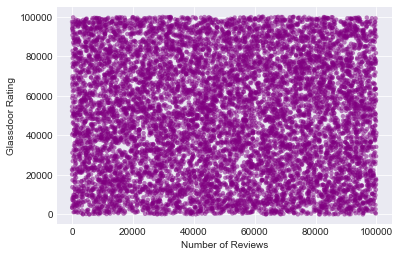

In [70]:
# Number of votes
sns.set_style('darkgrid')

dfs = pd.DataFrame(np.random.randint(100000, size=(10000, 2)),
                  columns=['Reviews', 'Rating'])
#dfs = pd.DataFrame(columns=['Rating'])
#dfs.apply(pd.to_numeric)

#dfs.plot(kind='scatter', x='Rating', y='Reviews')
dfs.plot(kind='scatter', x='Reviews', y='Rating', logx=False, alpha=0.5, color='purple', edgecolor='')
plt.ylabel('Glassdoor Rating')
plt.xlabel('Number of Reviews')
plt.show()

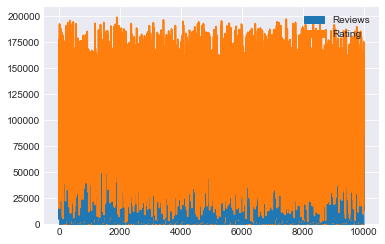

In [71]:
dfs.plot.area()

In [72]:
# Plot of how company rating changed over time

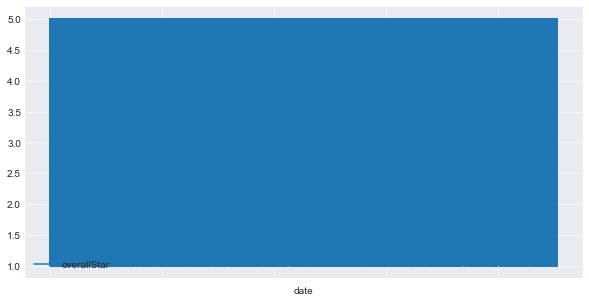

In [73]:
df.plot(x='date', y='overallStar' ,figsize=(10,5), grid=True  )


In [ ]:
# Plot of company stock price comparison to rating 